In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy as pt
import seaborn as sns
from sklearn import preprocessing
import re

import pickle
from os.path import join
from glob import glob

In [ ]:
def flatten_dict(d):
    new_d = {k2 : v2 for k1, v1 in d.items() for k2, v2 in v1.items() }
    return new_d


def parse_result(res):
    res_d = res[0]
    scores = res[1]
    new_d = flatten_dict(res_d)
    new_d['lb'] = [np.quantile(scores, 0.025)]
    new_d['y'] = [np.quantile(scores, 0.5)]
    new_d['ub'] = [np.quantile(scores, 0.975)]
    return new_d


def parse_result_all_vals(res):
    res_d = res[0]
    scores = res[1]
    new_d = flatten_dict(res_d)
    n_obs = len(scores)
    new_d = {k: np.repeat(v, n_obs) for k, v in new_d.items()}
    new_d['y'] = scores
    return new_d

def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_model_1(y, X, kernel_type='rbf', use_sparse=True):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    
    kernel_type = kernel_type.lower()
    
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1 # proportion of observations to use as inducing variables
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if use_sparse:
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

            # Marginal likelihood
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        mp = pm.find_MAP()
        
    return gp, mp, model

def create_dmatrix(df, formula, target):
    # create data matrix/dataframe
    # X = raw data matrix
    # Xc = (dummy) coded matrix
    if (target is not None) and (target in df.columns): 
        y = df.loc[:, target]
    else:
        y = None
    
    # dummy coding of basis
    Xc = pt.dmatrix(formula, data=df, return_type='dataframe')
    Xc = Xc.rename(columns=lambda x: re.sub('C','',x))
    
    return y, Xc

def scale_dmatrix(X, scaler=None):
    # scales matrices and returns scaler
    if scaler is None: 
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(X.values)
    
    Xs = scaler.transform(X.values)
    Xs = pd.DataFrame(Xs, columns=[x+'_s' for x in X.columns], index=X.index)
    return Xs, scaler

# Fit GPs to results

In [ ]:
sim_names = ['transition_state', 'reactant']
features = ['contact_filtered', 'phi_psi', 'alpha']
data_dir = 'hp_sampling'

Get the results into a master dataframe

In [ ]:
all_dfs = []
for sim in sim_names:
    for feature in features:
        trial_paths = glob(f"{data_dir}/{sim}_{feature}_*.p")
        if len(trial_paths) > 0:
            for trial_path in trial_paths:
                res = pickle.load(open(trial_path, 'rb'))
                data = parse_result(res)
                data['state'] = sim
                data['feature'] = feature
                n_obs = len(data['y'])
                all_dfs.append(pd.DataFrame(data, index=np.arange(n_obs)))
df = pd.concat(all_dfs)
df = df.reset_index(drop=True)
df.head()

,dim,lag,k,max_iter,lb,y,ub,state,feature
0,5,189,32,1000,2.490995,2.729323,2.842613,transition_state,contact_filtered
1,6,76,32,1000,2.470326,2.707967,2.831768,transition_state,contact_filtered
2,10,12,181,1000,2.662837,2.805909,2.917998,transition_state,contact_filtered
3,7,75,67,1000,2.571929,2.756233,2.899490,transition_state,contact_filtered
4,2,55,85,1000,2.334131,2.635141,2.771756,transition_state,contact_filtered


Create a grid of values to scale the hyperparameters

In [ ]:
search_space = pickle.load(open('common/hp_search_space.p', 'rb'))
search_space = flatten_dict(search_space)
del search_space['max_iter']

# extract from dictionary to keep order consistent
ss = [[k, v] for k, v in search_space.items()]
vals = [x[1] for x in ss]
keys = [x[0] for x in ss]

grid = np.meshgrid(*vals)
grid = np.concatenate([x.reshape(-1, 1) for x in grid], axis=1)
scaler = preprocessing.MinMaxScaler()
scaler.fit(grid)

MinMaxScaler()

In [ ]:
sim = 'transition_state'
feature = 'contact_filtered'

results = df.loc[(df['state']==sim), keys+['feature', 'y']]

In [ ]:
y, X = create_dmatrix(results, formula='0+dim+lag+k+C(feature)', target='y')
# this preserves the index!
Xs, _ = scale_dmatrix(X.loc[:, keys], scaler=scaler)
Xs = Xs.join(X.loc[:, X.columns.difference(keys)])

In [ ]:
# Fit gp model
gp, mp, model = fit_model_1(y=y, X=Xs, kernel_type='m52', use_sparse=False)

# Get predictions for evalution
with model:
    # predict target (includes noise)
    mu, var = gp.predict(Xs.values, point=mp, diag=True,pred_noise=True)
    sd = np.sqrt(var)

(2.0, 3.0)

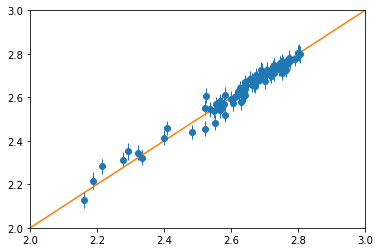

In [ ]:
lims = (2, 3)
plt.errorbar(y, mu, yerr=sd, lw=0, marker='o', elinewidth=1, alpha=1)
plt.plot(lims, lims)
plt.ylim(lims)
plt.xlim(lims)

In [ ]:
results.loc[np.argsort(mu)[::-1], :]

,dim,lag,k,feature,y
6,9,63,129,contact_filtered,2.801047
20,10,144,67,contact_filtered,2.801575
2,10,12,181,contact_filtered,2.805909
55,10,104,161,phi_psi,2.773073
58,10,238,188,phi_psi,2.791566
...,...,...,...,...,...
41,2,154,96,phi_psi,2.334643
43,3,98,22,phi_psi,2.278122
39,2,95,157,phi_psi,2.214225
59,1,17,21,alpha,2.188601
